In [1]:
import uproot
import awkward as ak
import numpy as np
import math
import sklearn.metrics as m
import numba as nb
from coffea.nanoevents.methods import vector
from coffea.nanoevents import NanoEventsFactory, BaseSchema, NanoAODSchema
import os

import boost_histogram as bh
from matplotlib import pyplot as plt
import matplotlib as mpl
from cycler import cycler
import mplhep as hep
use_helvet = False  ## true: use helvetica for plots, make sure the system have the font installed
if use_helvet:
    CMShelvet = hep.style.CMS
    CMShelvet['font.sans-serif'] = ['Helvetica', 'Arial']
    plt.style.use(CMShelvet)
else:
    plt.style.use(hep.style.CMS)

import os, sys  

# os.environ['OPENBLAS_NUM_THREADS'] = '1'

class dotdict(dict):
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__
    
#env:lpr


In [2]:
plot_dir = "../plots/Xcb_val/23Oct2024"
_ = os.system(f"mkdir -p {plot_dir}")

In [4]:
### find the score label index
labels = [
    #  H->2 prong
    "H_bb", "H_cc", "H_ss", "H_qq", "H_bc", "H_cs", "H_bq", "H_cq", "H_sq", "H_gg", "H_ee", "H_mm", "H_tauhtaue", "H_tauhtaum", "H_tauhtauh", 

    #  H->4/3 prong
    "H_AA_bbbb", "H_AA_bbcc", "H_AA_bbss", "H_AA_bbqq", "H_AA_bbgg", "H_AA_bbee", "H_AA_bbmm",
    "H_AA_bbtauhtaue", "H_AA_bbtauhtaum", "H_AA_bbtauhtauh",

    "H_AA_bbb", "H_AA_bbc", "H_AA_bbs", "H_AA_bbq", "H_AA_bbg", "H_AA_bbe", "H_AA_bbm",

    "H_AA_cccc", "H_AA_ccss", "H_AA_ccqq", "H_AA_ccgg", "H_AA_ccee", "H_AA_ccmm",
    "H_AA_cctauhtaue", "H_AA_cctauhtaum", "H_AA_cctauhtauh",

    "H_AA_ccb", "H_AA_ccc", "H_AA_ccs", "H_AA_ccq", "H_AA_ccg", "H_AA_cce", "H_AA_ccm",

    "H_AA_ssss", "H_AA_ssqq", "H_AA_ssgg", "H_AA_ssee", "H_AA_ssmm",
    "H_AA_sstauhtaue", "H_AA_sstauhtaum", "H_AA_sstauhtauh",

    "H_AA_ssb", "H_AA_ssc", "H_AA_sss", "H_AA_ssq", "H_AA_ssg", "H_AA_sse", "H_AA_ssm",

    "H_AA_qqqq", "H_AA_qqgg", "H_AA_qqee", "H_AA_qqmm",
    "H_AA_qqtauhtaue", "H_AA_qqtauhtaum", "H_AA_qqtauhtauh",

    "H_AA_qqb", "H_AA_qqc", "H_AA_qqs", "H_AA_qqq", "H_AA_qqg", "H_AA_qqe", "H_AA_qqm",

    "H_AA_gggg", "H_AA_ggee", "H_AA_ggmm",
    "H_AA_ggtauhtaue", "H_AA_ggtauhtaum", "H_AA_ggtauhtauh",

    "H_AA_ggb", "H_AA_ggc", "H_AA_ggs", "H_AA_ggq", "H_AA_ggg", "H_AA_gge", "H_AA_ggm",

    "H_AA_bee", "H_AA_cee", "H_AA_see", "H_AA_qee", "H_AA_gee",
    "H_AA_bmm", "H_AA_cmm", "H_AA_smm", "H_AA_qmm", "H_AA_gmm",

    "H_AA_btauhtaue", "H_AA_ctauhtaue", "H_AA_stauhtaue", "H_AA_qtauhtaue", "H_AA_gtauhtaue",
    "H_AA_btauhtaum", "H_AA_ctauhtaum", "H_AA_stauhtaum", "H_AA_qtauhtaum", "H_AA_gtauhtaum",
    "H_AA_btauhtauh", "H_AA_ctauhtauh", "H_AA_stauhtauh", "H_AA_qtauhtauh", "H_AA_gtauhtauh",

    #  (H+H-: H_AA_bbcs, H_AA_bbsq, H_AA_ssbc, H_AA_ssbq not available)
    "H_AA_qqqb", "H_AA_qqqc", "H_AA_qqqs",
    "H_AA_bbcq",
    "H_AA_ccbs", "H_AA_ccbq", "H_AA_ccsq",
    "H_AA_sscq",
    "H_AA_qqbc", "H_AA_qqbs", "H_AA_qqcs",
    "H_AA_bcsq",

    "H_AA_bcs", "H_AA_bcq", "H_AA_bsq", "H_AA_csq", 

    "H_AA_bcev", "H_AA_csev", "H_AA_bqev", "H_AA_cqev", "H_AA_sqev", "H_AA_qqev",
    "H_AA_bcmv", "H_AA_csmv", "H_AA_bqmv", "H_AA_cqmv", "H_AA_sqmv", "H_AA_qqmv",
    "H_AA_bctauev", "H_AA_cstauev", "H_AA_bqtauev", "H_AA_cqtauev", "H_AA_sqtauev", "H_AA_qqtauev",
    "H_AA_bctaumv", "H_AA_cstaumv", "H_AA_bqtaumv", "H_AA_cqtaumv", "H_AA_sqtaumv", "H_AA_qqtaumv",
    "H_AA_bctauhv", "H_AA_cstauhv", "H_AA_bqtauhv", "H_AA_cqtauhv", "H_AA_sqtauhv", "H_AA_qqtauhv",


    "QCD_bbccss", "QCD_bbccs", "QCD_bbcc", "QCD_bbcss", "QCD_bbcs", "QCD_bbc", "QCD_bbss", "QCD_bbs", "QCD_bb",
    "QCD_bccss", "QCD_bccs", "QCD_bcc", "QCD_bcss", "QCD_bcs", "QCD_bc", "QCD_bss", "QCD_bs", "QCD_b",
    "QCD_ccss", "QCD_ccs", "QCD_cc", "QCD_css", "QCD_cs", "QCD_c", "QCD_ss", "QCD_s", "QCD_light",

]

index_hbb = labels.index("H_bb")
index_hcc = labels.index("H_cc")
index_qcd_start = labels.index("QCD_bbccss")
index_qcdcc = labels.index("QCD_cc")

In [14]:
def get_hbbvsqcd(df):
    df["hbb"] = df["jet_probs"][:,index_hbb]
    df["qcd"] = ak.sum(df["jet_probs"][:,index_qcd_start:], axis = 1)
    df["hbbvsqcd"] = df["hbb"]/(df["hbb"] + df["qcd"])
    
def get_hccvsqcd(df):
    df["hcc"] = df["jet_probs"][:,index_hcc]
    df["qcd"] = ak.sum(df["jet_probs"][:,index_qcd_start:], axis = 1)
    df["hccvsqcd"] = df["hcc"]/(df["hcc"] + df["qcd"])
    
def get_hccvsqcdcc(df):
    df["hcc"] = df["jet_probs"][:,index_hcc]
    df["qcdcc"] = df["jet_probs"][:,index_qcdcc]
    df["hccvsqcdcc"] = df["hcc"]/(df["hcc"] + df["qcdcc"])
    

In [6]:
len(labels)

188

# Check Hbb ROC

In [15]:
df0_bb = uproot.lazy('/data/bond/zhaoyz/Pheno/ttbar_Wcb/Xcb_tag_val/SingleHiggsToBB_ntuple/Hbb.root')
df1_bb = uproot.lazy('/data/bond/zhaoyz/Pheno/ttbar_Wcb/Xcb_tag_val/QCD_ntuple/QCD.root')
get_hbbvsqcd(df0_bb)
get_hbbvsqcd(df1_bb)
df0_bb["event_type"] = 1.0
df1_bb["event_type"] = 0.0

df0_cc = uproot.lazy('/data/bond/zhaoyz/Pheno/ttbar_Wcb/Xcb_tag_val/SingleHiggsToCC_ntuple/Hcc.root')
df1_cc = uproot.lazy('/data/bond/zhaoyz/Pheno/ttbar_Wcb/Xcb_tag_val/QCD_ntuple/QCD.root')
get_hccvsqcd(df0_cc)
get_hccvsqcd(df1_cc)
df0_cc["event_type"] = 1.0
df1_cc["event_type"] = 0.0

In [17]:
df_bb = ak.concatenate([df0_bb, df1_bb])
df_cc = ak.concatenate([df0_cc, df1_cc])

/tmp/ipykernel_2186847/4229449407.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_true = ak.to_numpy(df_cut.event_type).astype(np.int)
/tmp/ipykernel_2186847/4229449407.py:36: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.


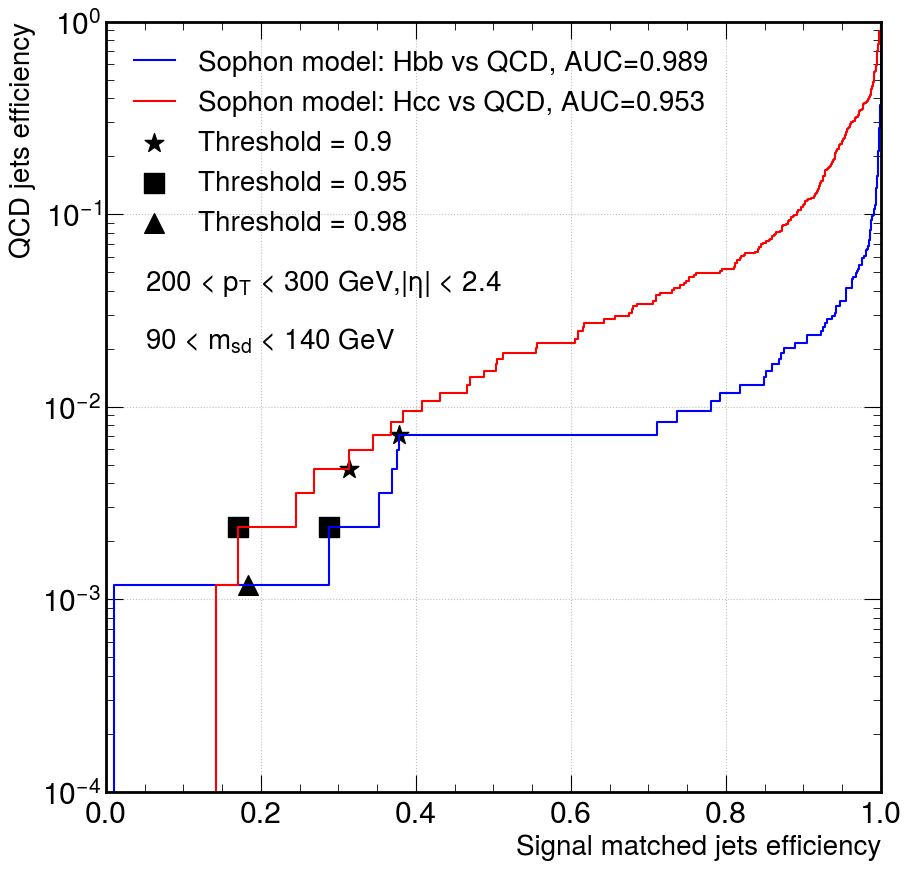

In [56]:
f, ax = plt.subplots(figsize=(10,10))
ax.grid()

# bb

df_cut = df_bb[(df_bb.jet_pt >= 200) & (df_bb.jet_pt <= 300) & (df_bb.jet_sdmass >= 90) & (df_bb.jet_sdmass <= 140) & (df_bb.jet_eta > -2.4) & (df_bb.jet_eta < 2.4)]
y_score =  np.nan_to_num(ak.to_numpy(df_cut.hbbvsqcd))
y_true = ak.to_numpy(df_cut.event_type).astype(np.int)
fpr, tpr, thres = m.roc_curve(y_true, y_score)
ax.plot(tpr, fpr, label=f'Sophon model: Hbb vs QCD, AUC={m.auc(fpr, tpr):.3f}', color = "blue")

threshold_value = 0.9
index = np.argmin(np.abs(thres - threshold_value))
fpr_value = fpr[index]
tpr_value = tpr[index]
ax.scatter(tpr_value, fpr_value, color='black', marker='*', s=200)

threshold_value = 0.95
index = np.argmin(np.abs(thres - threshold_value))
fpr_value = fpr[index]
tpr_value = tpr[index]
ax.scatter(tpr_value, fpr_value, color='black', marker='s', s=200)

threshold_value = 0.98
index = np.argmin(np.abs(thres - threshold_value))
fpr_value = fpr[index]
tpr_value = tpr[index]
ax.scatter(tpr_value, fpr_value, color='black', marker='^', s=200)



# cc

df_cut = df_cc[(df_cc.jet_pt >= 200) & (df_cc.jet_pt <= 300) & (df_cc.jet_sdmass >= 90) & (df_cc.jet_sdmass <= 140) & (df_cc.jet_eta > -2.4) & (df_cc.jet_eta < 2.4)]
y_score =  np.nan_to_num(ak.to_numpy(df_cut.hccvsqcd))
y_true = ak.to_numpy(df_cut.event_type).astype(np.int)
fpr, tpr, thres = m.roc_curve(y_true, y_score)
ax.plot(tpr, fpr, label=f'Sophon model: Hcc vs QCD, AUC={m.auc(fpr, tpr):.3f}', color = "red")

threshold_value = 0.9
index = np.argmin(np.abs(thres - threshold_value))
fpr_value = fpr[index]
tpr_value = tpr[index]
ax.scatter(tpr_value, fpr_value, color='black', marker='*', s=200, label=f'Threshold = {threshold_value}')


threshold_value = 0.95
index = np.argmin(np.abs(thres - threshold_value))
fpr_value = fpr[index]
tpr_value = tpr[index]
ax.scatter(tpr_value, fpr_value, color='black', marker='s', s=200, label=f'Threshold = {threshold_value}')

threshold_value = 0.98
index = np.argmin(np.abs(thres - threshold_value))
fpr_value = fpr[index]
tpr_value = tpr[index]
ax.scatter(tpr_value, fpr_value, color='black', marker='^', s=200, label=f'Threshold = {threshold_value}')

# others

ax.set_xlabel('Signal matched jets efficiency', ha='right', x=1.0, fontsize = 20); 
ax.set_ylabel('QCD jets efficiency', ha='right', y=1.0, fontsize = 20);
ax.set_xlim(0, 1); ax.set_ylim(1e-4, 1);
ax.set_yscale('log')
ax.legend(loc = "upper left", fontsize = 20)

# ax.text(0.9,0.15,"H -> bb vs QCD")
ax.text(0.05,0.040,"200 < $p_T$ < 300 GeV,|$\eta$| < 2.4", fontsize = 20)
ax.text(0.05,0.02,"90 < $m_{sd}$ < 140 GeV",fontsize = 20)

plt.savefig(f"{plot_dir}/ROC_hbb_200_300.pdf")
plt.show()

In [36]:
index = np.argmin(np.abs(thres - threshold_value))
index

10

/tmp/ipykernel_2186847/1250265675.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_true = ak.to_numpy(df_cut.event_type).astype(np.int)
/tmp/ipykernel_2186847/1250265675.py:32: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.


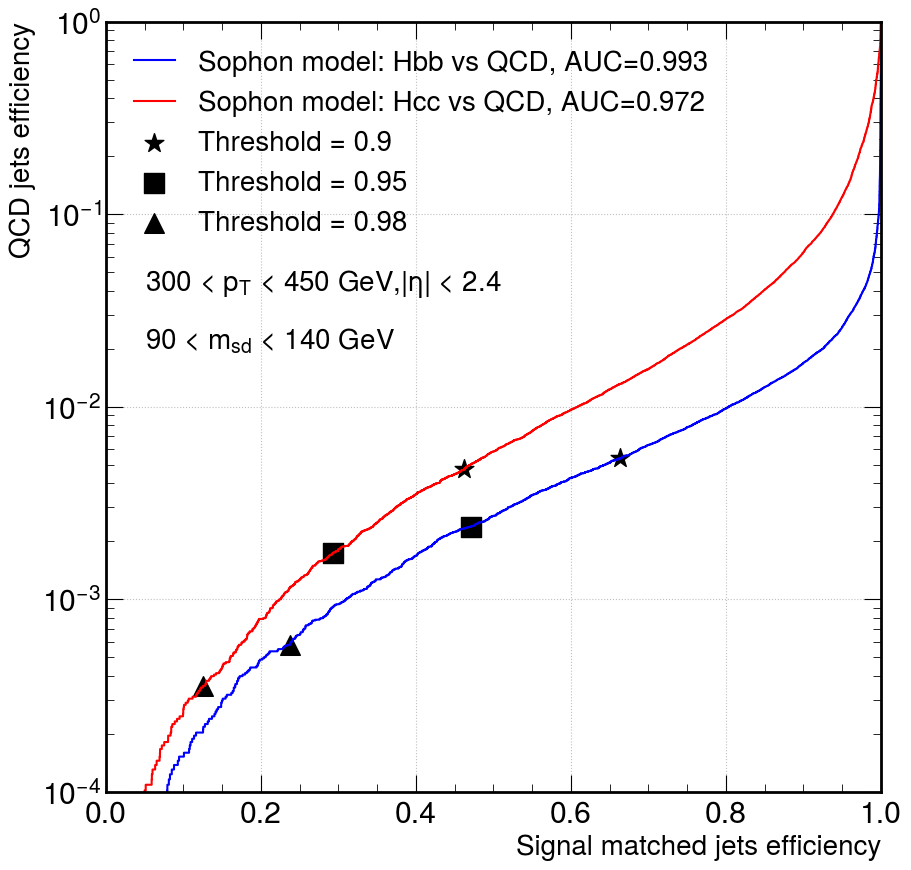

In [55]:
f, ax = plt.subplots(figsize=(10,10))
ax.grid()

df_cut = df_bb[(df_bb.jet_pt >= 300) & (df_bb.jet_pt <= 450) & (df_bb.jet_sdmass >= 90) & (df_bb.jet_sdmass <= 140) & (df_bb.jet_eta > -2.4) & (df_bb.jet_eta < 2.4)]
y_score =  np.nan_to_num(ak.to_numpy(df_cut.hbbvsqcd))
y_true = ak.to_numpy(df_cut.event_type).astype(np.int)
fpr, tpr, thres = m.roc_curve(y_true, y_score)
ax.plot(tpr, fpr, label=f'Sophon model: Hbb vs QCD, AUC={m.auc(fpr, tpr):.3f}', color = "blue")

threshold_value = 0.9
index = np.argmin(np.abs(thres - threshold_value))
fpr_value = fpr[index]
tpr_value = tpr[index]
ax.scatter(tpr_value, fpr_value, color='black', marker='*', s=200)

threshold_value = 0.95
index = np.argmin(np.abs(thres - threshold_value))
fpr_value = fpr[index]
tpr_value = tpr[index]
ax.scatter(tpr_value, fpr_value, color='black', marker='s', s=200)

threshold_value = 0.98
index = np.argmin(np.abs(thres - threshold_value))
fpr_value = fpr[index]
tpr_value = tpr[index]
ax.scatter(tpr_value, fpr_value, color='black', marker='^', s=200)



df_cut = df_cc[(df_cc.jet_pt >= 300) & (df_cc.jet_pt <= 450) & (df_cc.jet_sdmass >= 90) & (df_cc.jet_sdmass <= 140) & (df_cc.jet_eta > -2.4) & (df_cc.jet_eta < 2.4)]
y_score =  np.nan_to_num(ak.to_numpy(df_cut.hccvsqcd))
y_true = ak.to_numpy(df_cut.event_type).astype(np.int)
fpr, tpr, thres = m.roc_curve(y_true, y_score)
ax.plot(tpr, fpr, label=f'Sophon model: Hcc vs QCD, AUC={m.auc(fpr, tpr):.3f}', color = "red")

threshold_value = 0.9
index = np.argmin(np.abs(thres - threshold_value))
fpr_value = fpr[index]
tpr_value = tpr[index]
ax.scatter(tpr_value, fpr_value, color='black', marker='*', s=200, label=f'Threshold = {threshold_value}')


threshold_value = 0.95
index = np.argmin(np.abs(thres - threshold_value))
fpr_value = fpr[index]
tpr_value = tpr[index]
ax.scatter(tpr_value, fpr_value, color='black', marker='s', s=200, label=f'Threshold = {threshold_value}')

threshold_value = 0.98
index = np.argmin(np.abs(thres - threshold_value))
fpr_value = fpr[index]
tpr_value = tpr[index]
ax.scatter(tpr_value, fpr_value, color='black', marker='^', s=200, label=f'Threshold = {threshold_value}')


ax.set_xlabel('Signal matched jets efficiency', ha='right', x=1.0, fontsize = 20); 
ax.set_ylabel('QCD jets efficiency', ha='right', y=1.0, fontsize = 20);
ax.set_xlim(0, 1); ax.set_ylim(1e-4, 1);
ax.set_yscale('log')
ax.legend(loc = "upper left", fontsize = 20)

# ax.text(0.9,0.15,"H -> bb vs QCD")
ax.text(0.05,0.040,"300 < $p_T$ < 450 GeV,|$\eta$| < 2.4", fontsize = 20)
ax.text(0.05,0.02,"90 < $m_{sd}$ < 140 GeV",fontsize = 20)

plt.savefig(f"{plot_dir}/ROC_hbb_300_450.pdf")
plt.show()

/tmp/ipykernel_2186847/335128710.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_true = ak.to_numpy(df_cut.event_type).astype(np.int)
/tmp/ipykernel_2186847/335128710.py:32: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
De

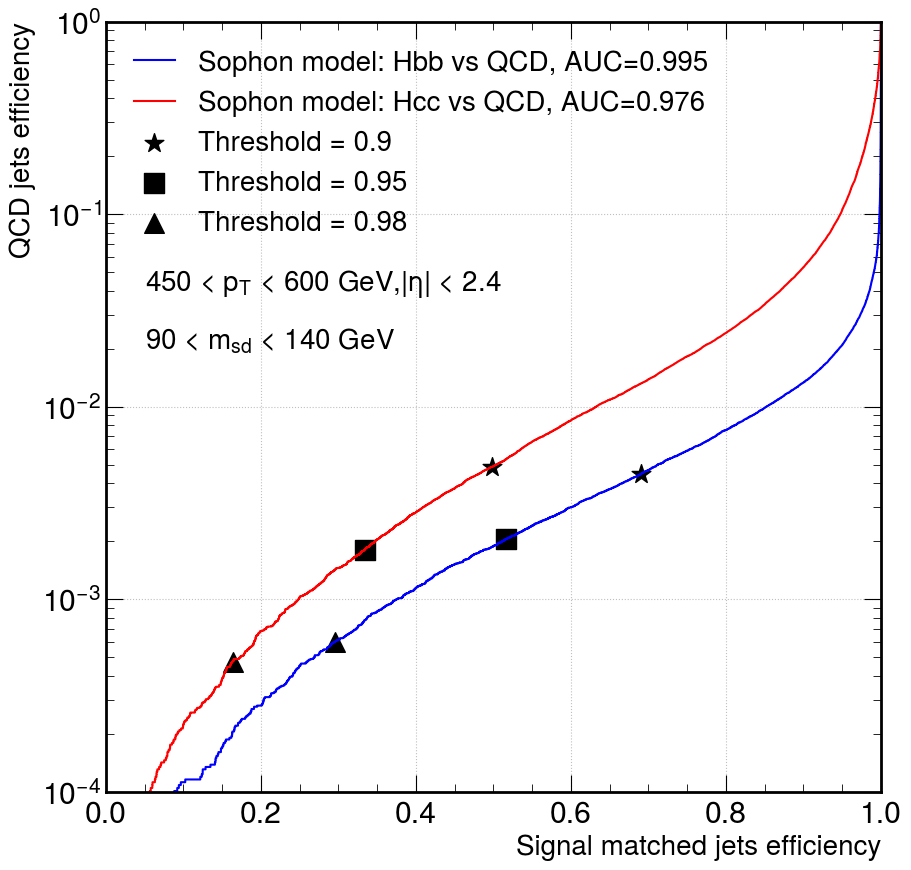

In [54]:
f, ax = plt.subplots(figsize=(10,10))
ax.grid()

df_cut = df_bb[(df_bb.jet_pt >= 450) & (df_bb.jet_pt <= 600) & (df_bb.jet_sdmass >= 90) & (df_bb.jet_sdmass <= 140) & (df_bb.jet_eta > -2.4) & (df_bb.jet_eta < 2.4)]
y_score =  np.nan_to_num(ak.to_numpy(df_cut.hbbvsqcd))
y_true = ak.to_numpy(df_cut.event_type).astype(np.int)
fpr, tpr, thres = m.roc_curve(y_true, y_score)
ax.plot(tpr, fpr, label=f'Sophon model: Hbb vs QCD, AUC={m.auc(fpr, tpr):.3f}', color = "blue")


threshold_value = 0.9
index = np.argmin(np.abs(thres - threshold_value))
fpr_value = fpr[index]
tpr_value = tpr[index]
ax.scatter(tpr_value, fpr_value, color='black', marker='*', s=200)

threshold_value = 0.95
index = np.argmin(np.abs(thres - threshold_value))
fpr_value = fpr[index]
tpr_value = tpr[index]
ax.scatter(tpr_value, fpr_value, color='black', marker='s', s=200)

threshold_value = 0.98
index = np.argmin(np.abs(thres - threshold_value))
fpr_value = fpr[index]
tpr_value = tpr[index]
ax.scatter(tpr_value, fpr_value, color='black', marker='^', s=200)


df_cut = df_cc[(df_cc.jet_pt >= 450) & (df_cc.jet_pt <= 600) & (df_cc.jet_sdmass >= 90) & (df_cc.jet_sdmass <= 140) & (df_cc.jet_eta > -2.4) & (df_cc.jet_eta < 2.4)]
y_score =  np.nan_to_num(ak.to_numpy(df_cut.hccvsqcd))
y_true = ak.to_numpy(df_cut.event_type).astype(np.int)
fpr, tpr, thres = m.roc_curve(y_true, y_score)
ax.plot(tpr, fpr, label=f'Sophon model: Hcc vs QCD, AUC={m.auc(fpr, tpr):.3f}', color = "red")


threshold_value = 0.9
index = np.argmin(np.abs(thres - threshold_value))
fpr_value = fpr[index]
tpr_value = tpr[index]
ax.scatter(tpr_value, fpr_value, color='black', marker='*', s=200, label=f'Threshold = {threshold_value}')


threshold_value = 0.95
index = np.argmin(np.abs(thres - threshold_value))
fpr_value = fpr[index]
tpr_value = tpr[index]
ax.scatter(tpr_value, fpr_value, color='black', marker='s', s=200, label=f'Threshold = {threshold_value}')

threshold_value = 0.98
index = np.argmin(np.abs(thres - threshold_value))
fpr_value = fpr[index]
tpr_value = tpr[index]
ax.scatter(tpr_value, fpr_value, color='black', marker='^', s=200, label=f'Threshold = {threshold_value}')


ax.set_xlabel('Signal matched jets efficiency', ha='right', x=1.0, fontsize = 20); 
ax.set_ylabel('QCD jets efficiency', ha='right', y=1.0, fontsize = 20);
ax.set_xlim(0, 1); ax.set_ylim(1e-4, 1);
ax.set_yscale('log')
ax.legend(loc = "upper left", fontsize = 20)

# ax.text(0.9,0.15,"H -> bb vs QCD")
ax.text(0.05,0.040,"450 < $p_T$ < 600 GeV,|$\eta$| < 2.4", fontsize = 20)
ax.text(0.05,0.02,"90 < $m_{sd}$ < 140 GeV",fontsize = 20)

plt.savefig(f"{plot_dir}/ROC_hbb_450_600.pdf")
plt.show()

### Check pT distribution

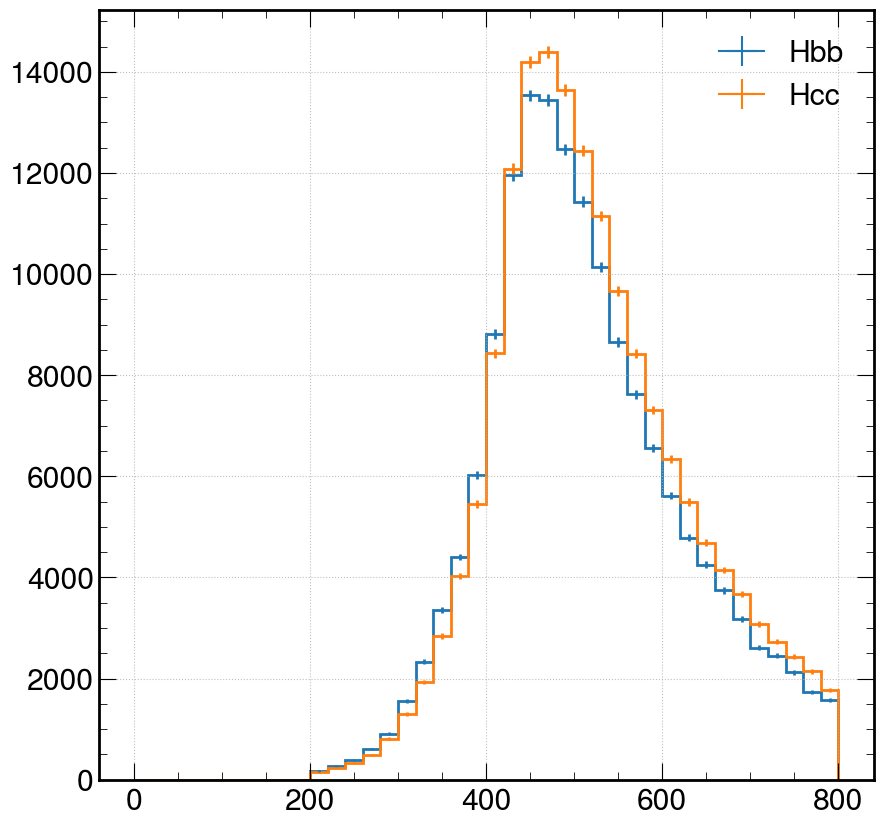

In [28]:
f, ax = plt.subplots(figsize=(10,10))
ax.grid()

hist1 = bh.Histogram(bh.axis.Regular(40, 0, 800), storage=bh.storage.Weight())
hist1.fill(df0_bb.jet_pt) #weight to be added in the future
h, var = hist1.view(flow=False).value, hist1.view(flow=False).variance
hep.histplot(h, bins=hist.axes[0].edges, yerr=np.sqrt(var), label="Hbb", histtype='step', density=False, stack=False, linewidth=2)


hist2 = bh.Histogram(bh.axis.Regular(40, 0, 800), storage=bh.storage.Weight())
hist2.fill(df0_cc.jet_pt) #weight to be added in the future
h, var = hist2.view(flow=False).value, hist2.view(flow=False).variance
hep.histplot(h, bins=hist2.axes[0].edges, yerr=np.sqrt(var), label="Hcc", histtype='step', density=False, stack=False, linewidth=2)

ax.legend()

/tmp/ipykernel_1275254/3487039369.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_true = ak.to_numpy(df_cut.event_type).astype(np.int)


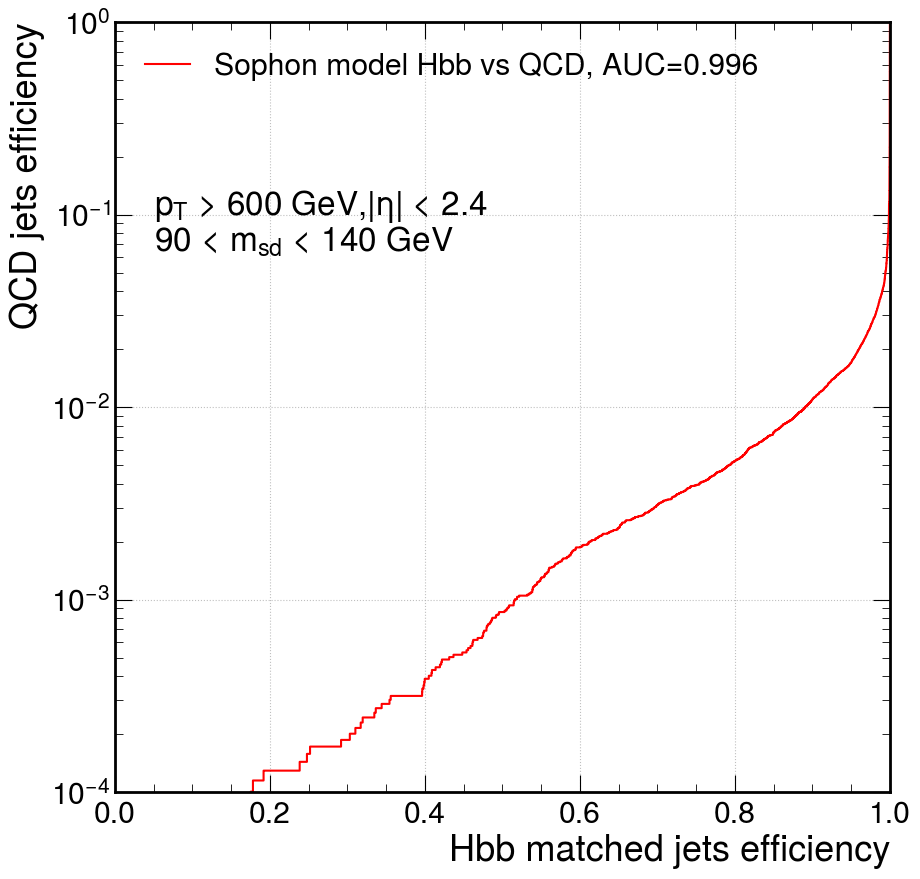

In [ ]:
f, ax = plt.subplots(figsize=(10,10))
ax.grid()
df_cut = df[(df.jet_pt >= 600) & (df.jet_sdmass >= 90) & (df.jet_sdmass <= 140) & (df.jet_eta > -2.4) & (df.jet_eta < 2.4)]
y_score =  np.nan_to_num(ak.to_numpy(df_cut.hbbvsqcd))
y_true = ak.to_numpy(df_cut.event_type).astype(np.int)
fpr, tpr, thres = m.roc_curve(y_true, y_score)
ax.plot(tpr, fpr, label=f'Sophon model Hbb vs QCD, AUC={m.auc(fpr, tpr):.3f}')

ax.set_xlabel('Hbb matched jets efficiency', ha='right', x=1.0); 
ax.set_ylabel('QCD jets efficiency', ha='right', y=1.0);
ax.set_xlim(0, 1); ax.set_ylim(1e-4, 1);
ax.set_yscale('log')
ax.legend(loc = "upper left")

# ax.text(0.9,0.15,"H -> bb vs QCD")
ax.text(0.05,0.1,"$p_T$ > 600 GeV,|$\eta$| < 2.4", fontsize = 24)
ax.text(0.05,0.065,"90 < $m_{sd}$ < 140 GeV",fontsize = 24)

plt.savefig(f"{plot_dir}/ROC_hbb_2.pdf")
plt.show()

# Check Hcc ROC

In [ ]:
df0 = uproot.lazy('/data/bond/zhaoyz/Pheno/ttbar_Wcb/Xcb_tag_val/SingleHiggsToCC_ntuple/Hcc.root')
df1 = uproot.lazy('/data/bond/zhaoyz/Pheno/ttbar_Wcb/Xcb_tag_val/QCD_ntuple/QCD.root')
get_hccvsqcd(df0)
get_hccvsqcd(df1)
df0["event_type"] = 1.0
df1["event_type"] = 0.0

In [ ]:
df = ak.concatenate([df0, df1])

/tmp/ipykernel_1275254/1459289576.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_true = ak.to_numpy(df_cut.event_type).astype(np.int)


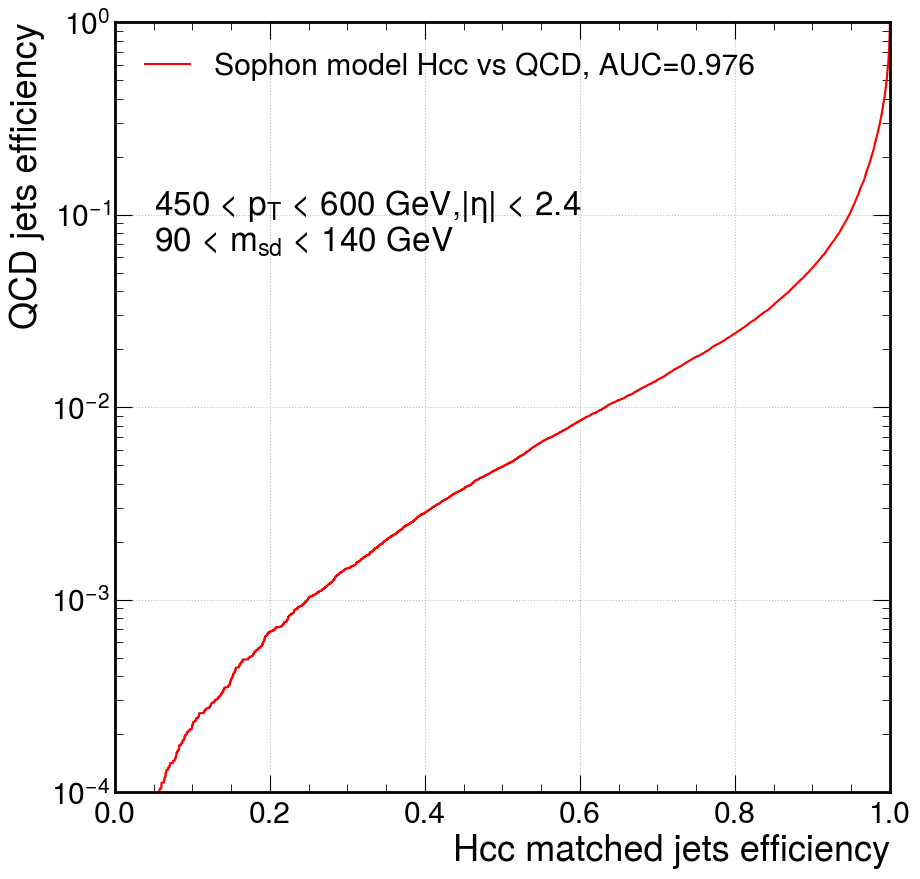

In [ ]:
f, ax = plt.subplots(figsize=(10,10))
ax.grid()
df_cut = df[(df.jet_pt >= 450) & (df.jet_pt <= 600) & (df.jet_sdmass >= 90) & (df.jet_sdmass <= 140) & (df.jet_eta > -2.4) & (df.jet_eta < 2.4)]
y_score =  np.nan_to_num(ak.to_numpy(df_cut.hbbvsqcd))
y_true = ak.to_numpy(df_cut.event_type).astype(np.int)
fpr, tpr, thres = m.roc_curve(y_true, y_score)
ax.plot(tpr, fpr, label=f'Sophon model Hcc vs QCD, AUC={m.auc(fpr, tpr):.3f}')

ax.set_xlabel('Hcc matched jets efficiency', ha='right', x=1.0); 
ax.set_ylabel('QCD jets efficiency', ha='right', y=1.0);
ax.set_xlim(0, 1); ax.set_ylim(1e-4, 1);
ax.set_yscale('log')
ax.legend(loc = "upper left")

# ax.text(0.9,0.15,"H -> bb vs QCD")
ax.text(0.05,0.1,"450 < $p_T$ < 600 GeV,|$\eta$| < 2.4", fontsize = 24)
ax.text(0.05,0.065,"90 < $m_{sd}$ < 140 GeV",fontsize = 24)

plt.savefig(f"{plot_dir}/ROC_hcc_1.pdf")
plt.show()

/tmp/ipykernel_1275254/606768773.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_true = ak.to_numpy(df_cut.event_type).astype(np.int)


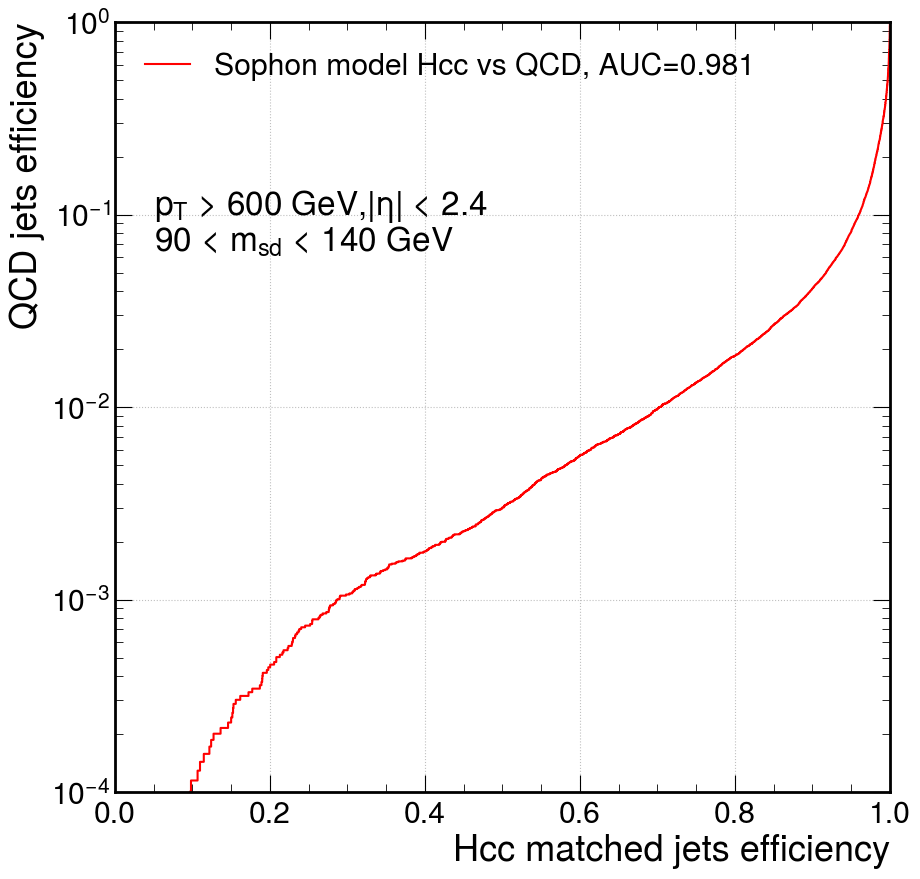

In [ ]:
f, ax = plt.subplots(figsize=(10,10))
ax.grid()
df_cut = df[(df.jet_pt >= 600) & (df.jet_sdmass >= 90) & (df.jet_sdmass <= 140) & (df.jet_eta > -2.4) & (df.jet_eta < 2.4)]
y_score =  np.nan_to_num(ak.to_numpy(df_cut.hbbvsqcd))
y_true = ak.to_numpy(df_cut.event_type).astype(np.int)
fpr, tpr, thres = m.roc_curve(y_true, y_score)
ax.plot(tpr, fpr, label=f'Sophon model Hcc vs QCD, AUC={m.auc(fpr, tpr):.3f}')

ax.set_xlabel('Hcc matched jets efficiency', ha='right', x=1.0); 
ax.set_ylabel('QCD jets efficiency', ha='right', y=1.0);
ax.set_xlim(0, 1); ax.set_ylim(1e-4, 1);
ax.set_yscale('log')
ax.legend(loc = "upper left")

# ax.text(0.9,0.15,"H -> bb vs QCD")
ax.text(0.05,0.1,"$p_T$ > 600 GeV,|$\eta$| < 2.4", fontsize = 24)
ax.text(0.05,0.065,"90 < $m_{sd}$ < 140 GeV",fontsize = 24)

plt.savefig(f"{plot_dir}/ROC_hcc_2.pdf")
plt.show()

# Check Hcc ROC

# Check Hcc ROC

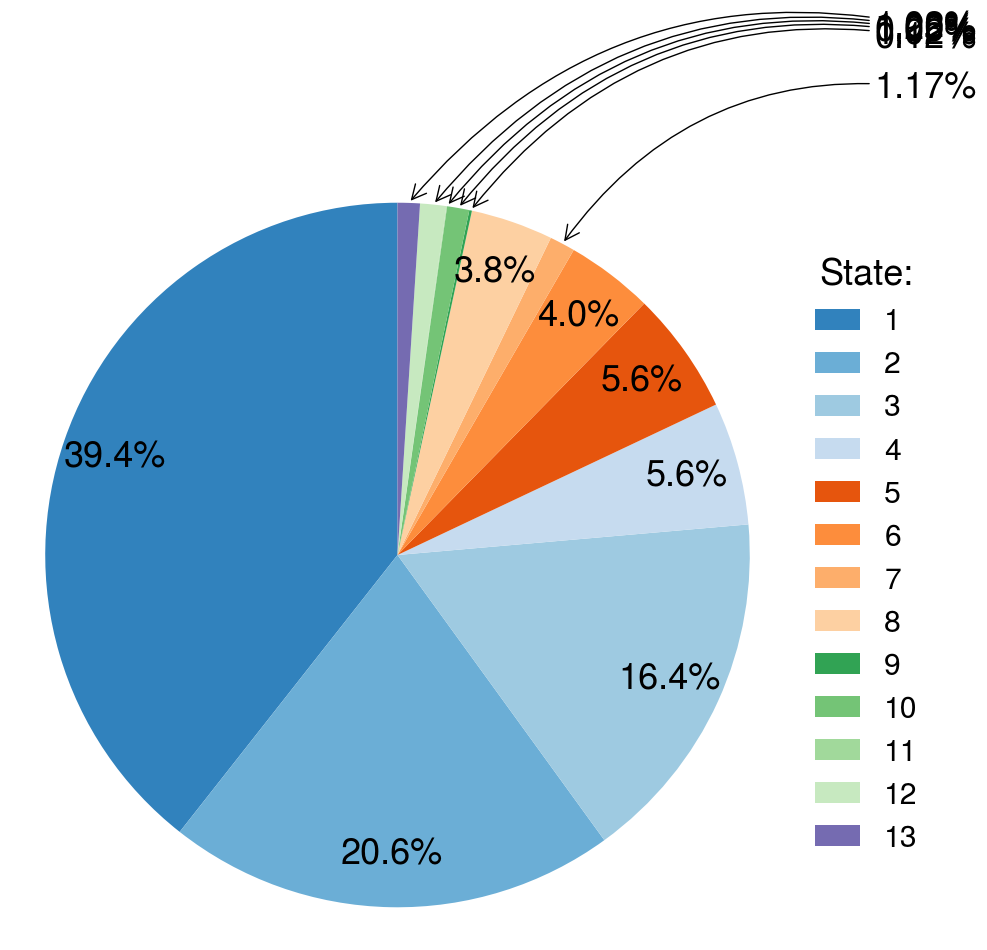

In [59]:
import matplotlib.pyplot as plt
import numpy as np

# 数据
sizes = [39.4, 20.6, 16.4, 5.64, 5.63, 4.01, 1.17, 3.78, 0.12, 1.02, 0.03, 1.2, 1.02]
labels = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13']
colors = plt.cm.tab20c(np.arange(len(sizes)))  # 使用颜色图

fig, ax = plt.subplots()

# 绘制饼图，取消小比例块的自动标注
wedges, texts, autotexts = ax.pie(sizes, startangle=90, colors=colors, autopct=lambda pct: f'{pct:.1f}%' if pct > 3 else '', pctdistance=0.85)

# 设置饼图为均等显示
ax.axis('equal')

# 手动为比例较小的块绘制带箭头的标注
for i, wedge in enumerate(wedges):
    if sizes[i] < 3:  # 针对比例较小的块，3%以下的块用箭头标注
        angle = (wedge.theta2 - wedge.theta1) / 2.0 + wedge.theta1
        x = wedge.r * np.cos(np.radians(angle))
        y = wedge.r * np.sin(np.radians(angle))
        
        # 调整注释文本的位置，使用箭头连接标注和小比例块
        ax.annotate(f'{sizes[i]:.2f}%', xy=(x, y), xytext=(1.5 * np.sign(x), 1.5 * y),
                    arrowprops=dict(facecolor='black', arrowstyle='->', connectionstyle='arc3,rad=0.3'),
                    horizontalalignment='center', verticalalignment='center')

# 添加图例
ax.legend(wedges, labels, title="State:", loc="center left", bbox_to_anchor=(1, 0.5))

# 显示图表
plt.show()


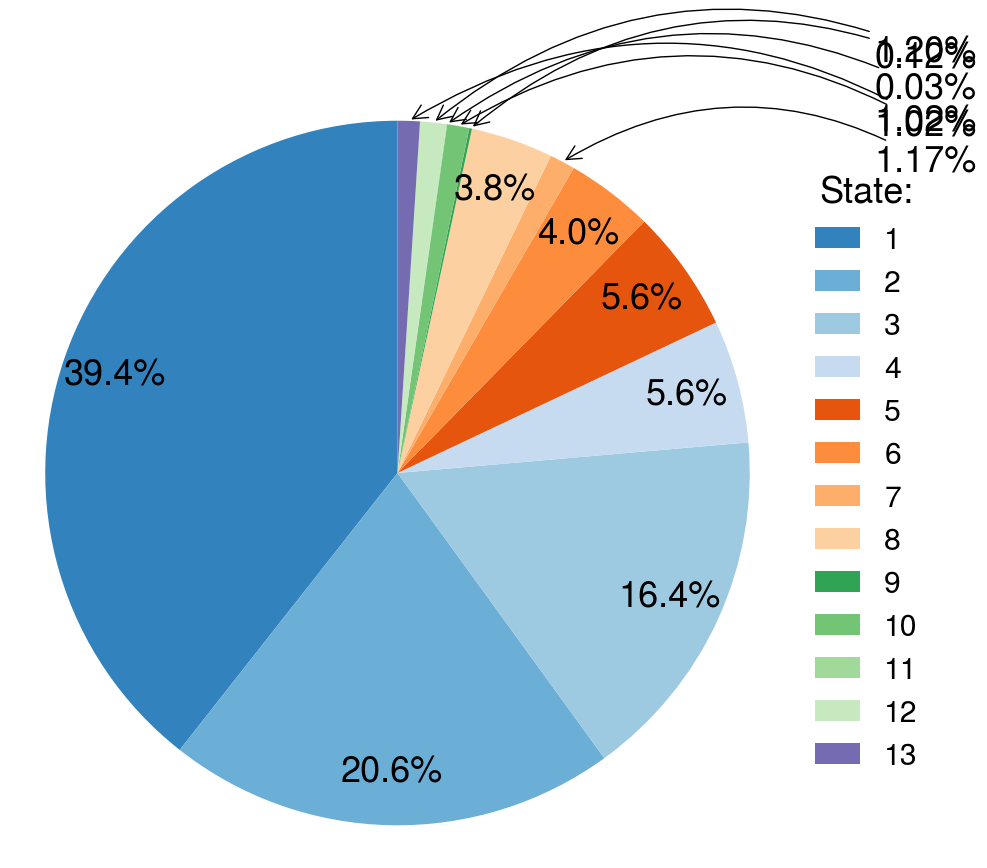

In [60]:
import matplotlib.pyplot as plt
import numpy as np

# 数据
sizes = [39.4, 20.6, 16.4, 5.64, 5.63, 4.01, 1.17, 3.78, 0.12, 1.02, 0.03, 1.2, 1.02]
labels = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13']
colors = plt.cm.tab20c(np.arange(len(sizes)))  # 使用颜色图

fig, ax = plt.subplots()

# 绘制饼图，取消小比例块的自动标注
wedges, texts, autotexts = ax.pie(sizes, startangle=90, colors=colors, autopct=lambda pct: f'{pct:.1f}%' if pct > 3 else '', pctdistance=0.85)

# 设置饼图为均等显示
ax.axis('equal')

# 手动为比例较小的块绘制带箭头的标注，并分散尾部位置
for i, wedge in enumerate(wedges):
    if sizes[i] < 3:  # 针对比例较小的块
        angle = (wedge.theta2 - wedge.theta1) / 2.0 + wedge.theta1
        x = wedge.r * np.cos(np.radians(angle))
        y = wedge.r * np.sin(np.radians(angle))
        
        # 根据 i 值分散标注的 y 位置
        y_offset = y + 0.1 * (i % 3)  # 调整尾部的位置来避免重叠
        
        # 调整注释文本的位置，使用箭头连接标注和小比例块
        ax.annotate(f'{sizes[i]:.2f}%', xy=(x, y), xytext=(1.5 * np.sign(x), y_offset),
                    arrowprops=dict(facecolor='black', arrowstyle='->', connectionstyle='arc3,rad=0.3'),
                    horizontalalignment='center', verticalalignment='center')

# 添加图例
ax.legend(wedges, labels, title="State:", loc="center left", bbox_to_anchor=(1, 0.5))

# 显示图表
plt.show()
